# Solar Event Data 
## Exploratory Data Analysis/Timeseries Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults,ARMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Always make it pretty.
plt.style.use('ggplot')
%matplotlib inline

In [2]:
df = pd.read_csv('full_clean_solar_features_data.csv')

In [3]:
df.head()

,Unnamed: 0,event,begin,max,end,obs,q,type,loc,freq,particulars,reg_num,date,yes_no,duration,del_begin_max,del_end_max,closer_begin_end
0,0,2310,1900-01-01 00:07:00,1900-01-01 00:13:00,1900-01-01 00:20:00,GO8,5,XRA,1-8A,C1.2,8.1E-04,NaN,2001-01-01 00:00:00,1.0,0 days 00:13:00.000000000,0 days 00:06:00.000000000,0 days 00:07:00.000000000,0.0
1,1,2470,1900-01-01 00:46:00,NaN,1900-01-01 00:46:00,CUL,C,RSP,40-100,III/1,NaN,NaN,2001-01-01 00:00:00,1.0,0 days 00:00:00.000000000,NaN,NaN,0.0
2,2,2320,1900-01-01 01:18:00,1900-01-01 01:21:00,1900-01-01 01:27:00,GO8,5,XRA,1-8A,C1.0,4.5E-04,NaN,2001-01-01 00:00:00,1.0,0 days 00:09:00.000000000,0 days 00:03:00.000000000,0 days 00:06:00.000000000,0.0
3,3,2350,1900-01-01 03:22:00,1900-01-01 03:34:00,1900-01-01 06:00:00,LEA,G,RNS,245,68,NaN,NaN,2001-01-01 00:00:00,1.0,0 days 02:38:00.000000000,0 days 00:12:00.000000000,0 days 02:26:00.000000000,0.0
4,4,2330,1900-01-01 03:39:00,1900-01-01 03:39:00,1900-01-01 03:39:00,PAL,G,RBR,245,52,NaN,NaN,2001-01-01 00:00:00,1.0,0 days 00:00:00.000000000,0 days 00:00:00.000000000,0 days 00:00:00.000000000,0.0


In [4]:
flare = df[df.type == 'FLA']

In [5]:
flare.head()

,Unnamed: 0,event,begin,max,end,obs,q,type,loc,freq,particulars,reg_num,date,yes_no,duration,del_begin_max,del_end_max,closer_begin_end
5,5,2340,1900-01-01 03:47:00,1900-01-01 03:49:00,1900-01-01 03:52:00,LEA,3,FLA,N25E45,SF,ERU,9292.0,2001-01-01 00:00:00,1.0,0 days 00:05:00.000000000,0 days 00:02:00.000000000,0 days 00:03:00.000000000,0.0
8,8,2360,1900-01-01 07:35:00,1900-01-01 07:35:00,1900-01-01 07:38:00,LEA,3,FLA,S09E13,SF,9289,NaN,2001-01-01 00:00:00,1.0,0 days 00:03:00.000000000,0 days 00:00:00.000000000,0 days 00:03:00.000000000,0.0
10,10,2370,1900-01-01 09:46:00,1900-01-01 09:54:00,1900-01-01 10:15:00,LEA,2,FLA,S11W46,SF,9283,NaN,2001-01-01 00:00:00,1.0,0 days 00:29:00.000000000,0 days 00:08:00.000000000,0 days 00:21:00.000000000,0.0
14,14,2400,1900-01-01 16:41:00,1900-01-01 16:43:00,1900-01-01 16:59:00,RAM,3,FLA,S12W52,SF,ERU,9283.0,2001-01-01 00:00:00,1.0,0 days 00:18:00.000000000,0 days 00:02:00.000000000,0 days 00:16:00.000000000,0.0
72,18,2940,1900-01-01 09:31:00,1900-01-01 09:33:00,1900-01-01 09:40:00,LEA,3,FLA,S03W16,SF,ERU,9289.0,2001-01-03 00:00:00,1.0,0 days 00:09:00.000000000,0 days 00:02:00.000000000,0 days 00:07:00.000000000,0.0


In [7]:
df.date = df.date.apply(lambda x: pd.to_datetime(x))

# Exploratory Data Analysis (EDA)

In [8]:
events = df.groupby(['date']).sum()
events.head()

,Unnamed: 0,reg_num,yes_no,closer_begin_end
date,,,,
2001-01-01,406,46430.0,29.0,3.0
2001-01-02,300,NaN,25.0,3.0
2001-01-03,1431,55746.0,54.0,9.0
2001-01-04,406,27879.0,29.0,4.0
2001-01-05,435,46510.0,30.0,4.0


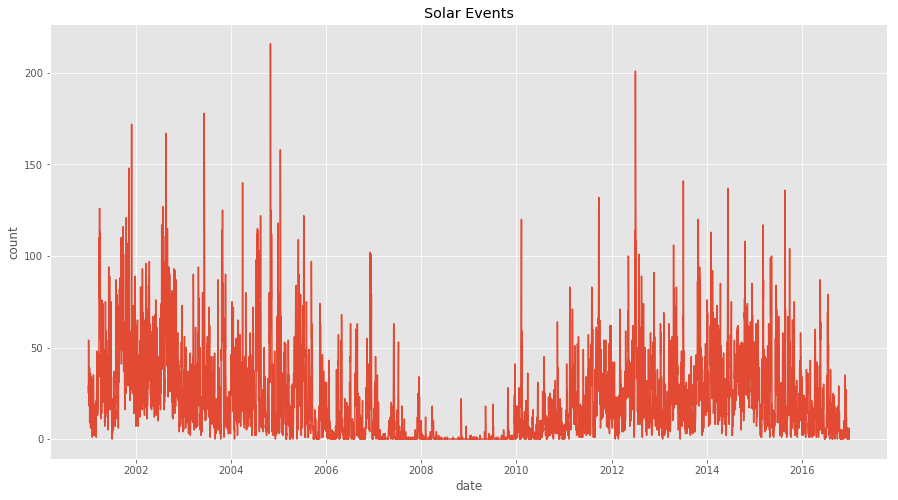

In [72]:
# Looks like the best way to represent the data. 
plt.figure(figsize=(15,8))
plt.plot(events.index, events.yes_no);
plt.title('Solar Events')
plt.xlabel('date')
plt.ylabel('count')
plt.show()

In [56]:
# Finding the date for the maximum number of events
events[events.yes_no == max(events.yes_no)]

,Unnamed: 0,reg_num,yes_no,closer_begin_end
date,,,,
2004-10-30,23220,23486.0,216.0,66.0


In [13]:
max_date = df[df.date == '2004-10-30']
max_date.head()

,Unnamed: 0,event,begin,max,end,obs,q,type,loc,freq,particulars,reg_num,date,yes_no,duration,del_begin_max,del_end_max,closer_begin_end
49040,0,270,1900-01-01 00:19:00,NaN,1900-01-01 06:11:00,LEA,C,RSP,075-180,CTM/1,NaN,NaN,2004-10-30,1.0,0 days 05:52:00.000000000,NaN,NaN,0.0
49041,1,210,1900-01-01 00:39:00,1900-01-01 00:49:00,1900-01-01 00:53:00,G12,5,XRA,1-8A,C9.7,3.9E-03,691.0,2004-10-30,1.0,0 days 00:14:00.000000000,0 days 00:10:00.000000000,0 days 00:04:00.000000000,1.0
49042,2,210,1900-01-01 00:42:00,1900-01-01 00:43:00,1900-01-01 00:44:00,LEA,G,RBR,245,220,0691,NaN,2004-10-30,1.0,0 days 00:02:00.000000000,0 days 00:01:00.000000000,0 days 00:01:00.000000000,0.0
49043,3,210,1900-01-01 00:42:00,1900-01-01 00:51:00,1900-01-01 00:52:00,G12,5,XFL,N14W19,3.1E03,2.4E04,691.0,2004-10-30,1.0,0 days 00:10:00.000000000,0 days 00:09:00.000000000,0 days 00:01:00.000000000,1.0
49044,4,210,1900-01-01 00:43:00,1900-01-01 00:43:00,1900-01-01 00:43:00,PAL,G,RBR,606,54,0691,NaN,2004-10-30,1.0,0 days 00:00:00.000000000,0 days 00:00:00.000000000,0 days 00:00:00.000000000,0.0


In [14]:
max_date_sum = df[df.date == '2004-10-30'].groupby(['begin']).sum()
max_date_sum.head()

,Unnamed: 0,reg_num,yes_no,closer_begin_end
begin,,,,
1900-01-01 00:19:00,0,NaN,1.0,0.0
1900-01-01 00:39:00,1,691.0,1.0,1.0
1900-01-01 00:42:00,5,691.0,2.0,1.0
1900-01-01 00:43:00,30,691.0,5.0,0.0
1900-01-01 00:47:00,19,NaN,2.0,2.0


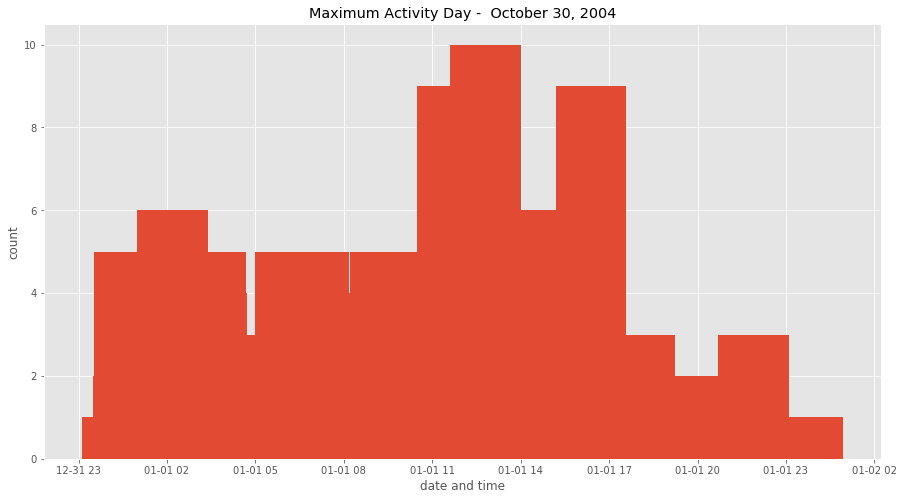

In [70]:
# The max solar event date.
plt.figure(figsize=[15,8])
plt.bar(pd.to_datetime(max_date_sum.index), max_date_sum.yes_no, width=0.1);
plt.title('Maximum Activity Day -  October 30, 2004')
plt.xlabel('date and time')
plt.ylabel('count')
plt.show()

** Looks like it hits the maximum amount of activity between 12 and 14 (universal time) ** 

In [16]:
decade_1 = events['2000':'2010']

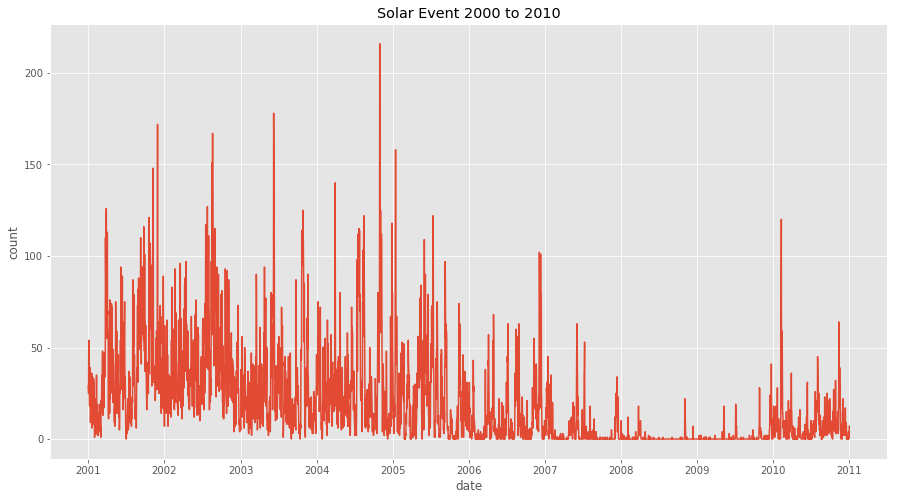

In [64]:
plt.figure(figsize=(15,8))
plt.plot(decade_1.index, decade_1.yes_no);
plt.title('Solar Event 2000 to 2010')
plt.xlabel('date')
plt.ylabel('count')
plt.show()

** I thought that this would be interesting because a full cycle is 11 years so we are looking at one cycle. You can clearly see a 'maximum' and a 'minimum' in the graph **

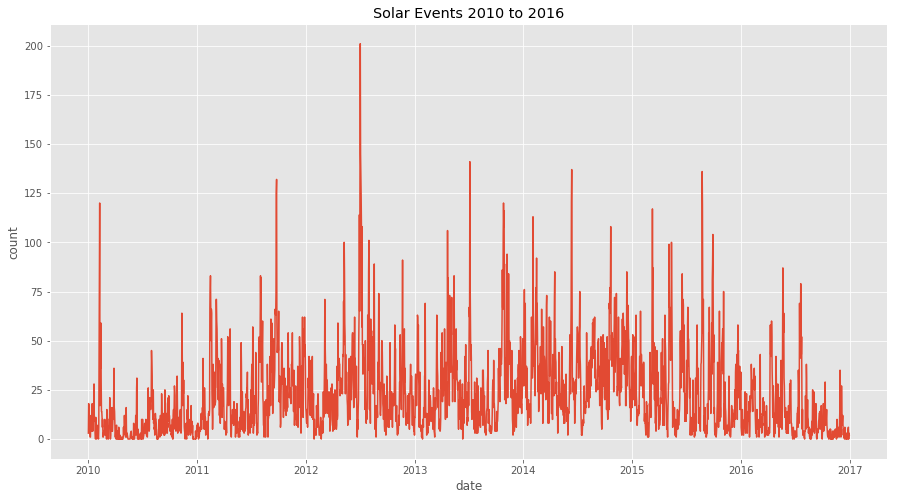

In [62]:
decade_2 = events['2010':'2016']
plt.figure(figsize=(15,8))
plt.plot(decade_2.index, decade_2.yes_no);
plt.title('Solar Events 2010 to 2016')
plt.xlabel('date')
plt.ylabel('count')
plt.show()

** This is the second half of the data, even though it is not as clear as above, you can see an arched pattern **

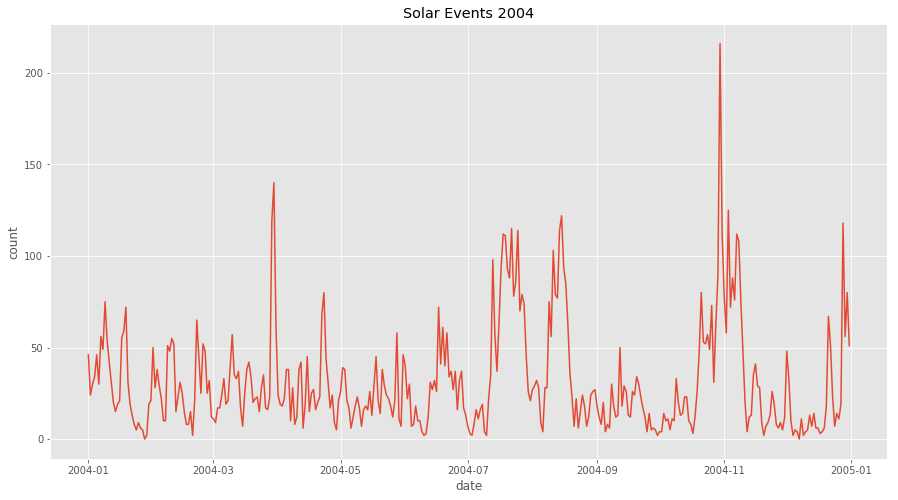

In [61]:
decade_2 = events['2004':'2004']
plt.figure(figsize=(15,8))
plt.plot(decade_2.index, decade_2.yes_no);
plt.title('Solar Events 2004')
plt.xlabel('date')
plt.ylabel('count')
plt.show()

**Looking at just one year and you can see a spike at the end of the year** 

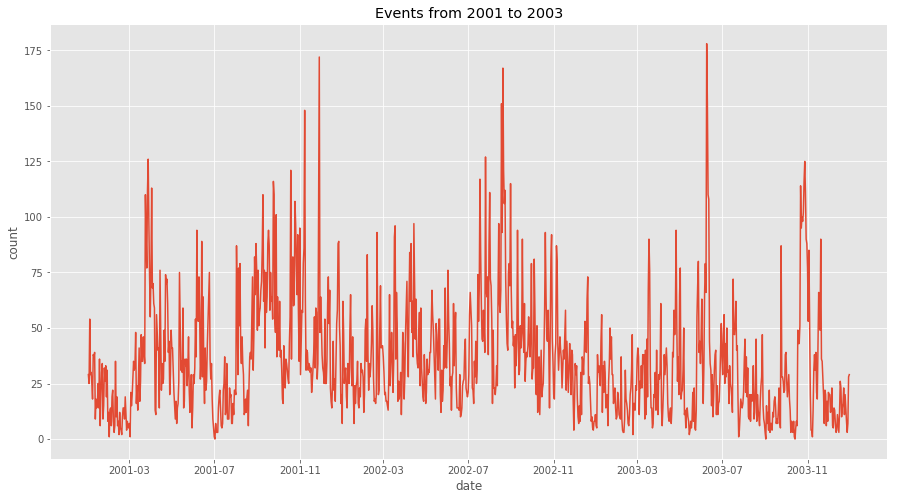

In [60]:
time = events['2001':'2003']
plt.figure(figsize=(15,8))
plt.plot(time.index, time.yes_no);
plt.title('Events from 2001 to 2003')
plt.xlabel('date')
plt.ylabel('count')
plt.show()

** Looking at three years, you can see a sort of arched pattern but it is not clear if there is any other patten but there is three major spikes (which could be seperated approximately equally)  **

In [21]:
# looking only at flares
flare = df[df.type == 'FLA']

In [22]:
flare_sum = flare.groupby(['date']).sum()

In [23]:
flare_sum.head()

,Unnamed: 0,reg_num,yes_no,closer_begin_end
date,,,,
2001-01-01,37,18575.0,4.0,0.0
2001-01-03,96,27873.0,3.0,0.0
2001-01-04,61,9289.0,3.0,0.0
2001-01-05,52,27906.0,4.0,1.0
2001-01-06,40,NaN,3.0,0.0


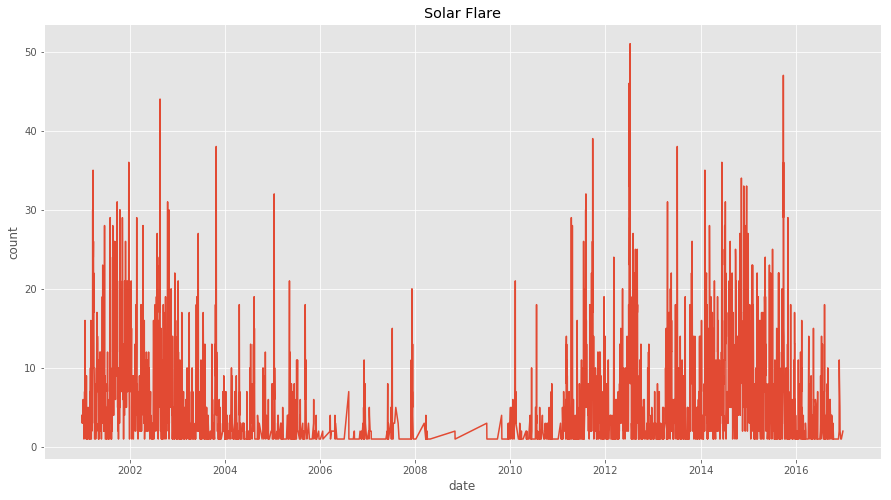

In [59]:
plt.figure(figsize=[15,8])
plt.plot(flare_sum.index, flare_sum.yes_no);
plt.title('Solar Flare')
plt.xlabel('date')
plt.ylabel('count')
plt.show()

** Can see a similar pattern when looking at all of the events together. However, one interesting feature is that the second arch seems to be more active then the first which is interesting since this is the opposite when you view all events. Also, the maximums of each arch does not seem to be centered but instead off to one side. **

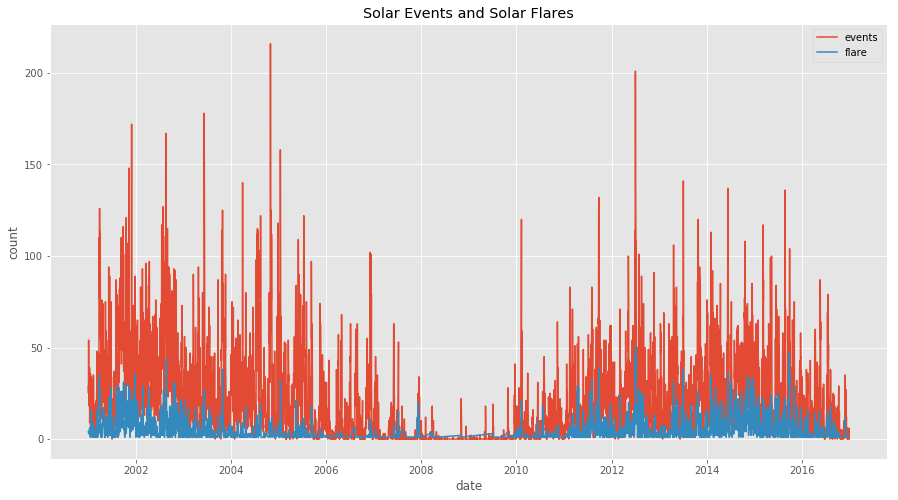

In [57]:
plt.figure(figsize=[15,8])
plt.plot(events.index, events.yes_no, label='events')
plt.plot(flare_sum.index, flare_sum.yes_no, label='flare');
plt.title('Solar Events and Solar Flares')
plt.xlabel('date')
plt.ylabel('count')
plt.legend()
plt.show()

** Showing both together you can see that they both follow a similar overall pattern. However, the solar events chart seem to have maximums at opposites sides of the arches compared to the solar flare data. I am surprised that the maximums do not seem to be in the same place every cycle. **

# Timeseries Analysis

In [26]:
series = pd.DataFrame(events.yes_no)
series.head()

,yes_no
date,
2001-01-01,29.0
2001-01-02,25.0
2001-01-03,54.0
2001-01-04,29.0
2001-01-05,30.0


In [27]:
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

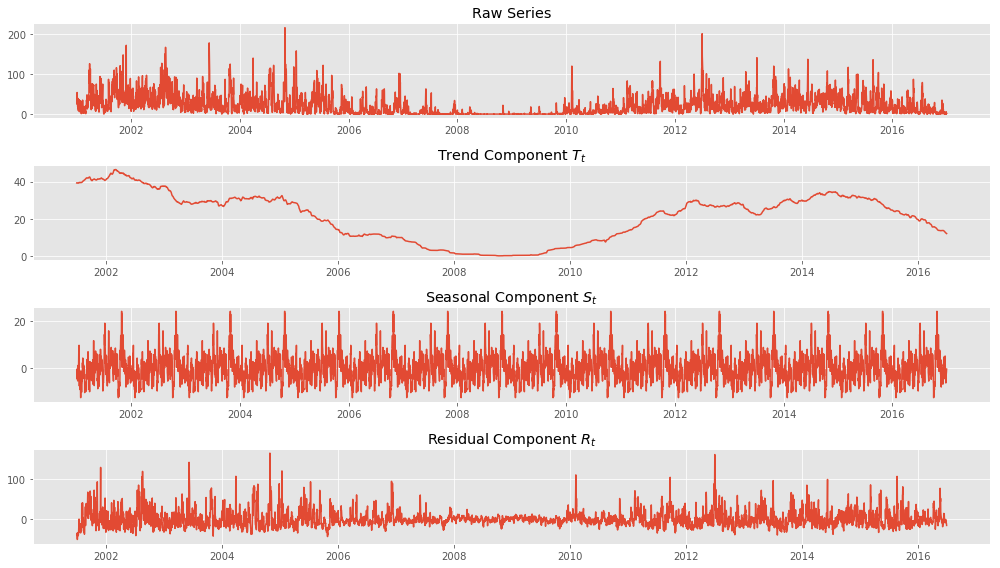

In [28]:
events_decomposition = sm.tsa.seasonal_decompose(series, freq=365)

fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, events.yes_no, events_decomposition)
plt.tight_layout()

** TREND **: This line you can see a clear pattern of up and down and back up. One interesting feature is that there appears to be two peaks with in the two prominent peaks. Also, the first prominent peak is more active than the second prominent peak.   

**SEASONAL**: There looks like there is a clear annual pattern with a peak around the end of every year. Also within each year you can see a downward trend that then does back up until it peaks.  

**RESIDUALS**: I would have expected 'errors' to look like this since there is far more variance in the data at the peaks.

In [29]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title(" Trend For {}".format(name))

In [30]:
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

In [31]:
event_series =  pd.DataFrame(events.yes_no)

The Augmented Dickey-Fuller test (adfuller) can be used to test for a unit root in a univariate process in the presence of serial correlation.

In [32]:
test = sm.tsa.stattools.adfuller(event_series.yes_no)
print("ADF p-value for solar event series: {0:2.2f}".format(test[1]))

ADF p-value for solar event series: 0.00


** The original series is stationary which surprises me since the decomposition show that there is clearly a trend and seasonality. **

In [33]:
test = sm.tsa.stattools.adfuller(event_series.yes_no.diff()[1:])
print("ADF p-value for differenced solar event series: {0:2.2f}".format(test[1]))

ADF p-value for differenced solar event series: 0.00


In [34]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

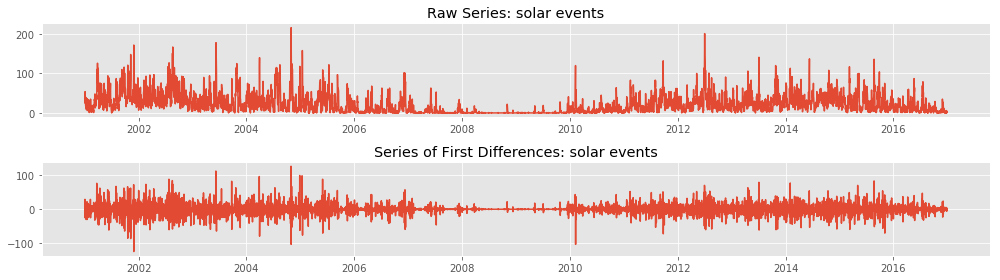

In [35]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, event_series.yes_no, 'solar events')
fig.tight_layout()

** The first difference looks like it does remove both the trend and seasonality. **

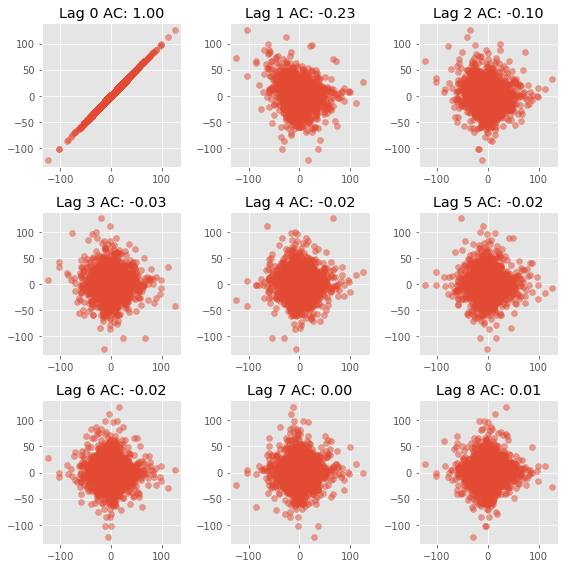

In [36]:
event_diff = event_series.yes_no.diff()[1:]

fig, axs = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axs.flatten()):
    series, lagged = series_and_lagged(event_diff, lag=i)
    autocorr = compute_autocorrelation(event_diff, lag=i)
    ax.scatter(series, lagged, alpha=0.5)
    ax.set_title("Lag {0} AC: {1:2.2f}".format(i, autocorr))
    
plt.tight_layout()

** Looks like two lages are above 0.05 **

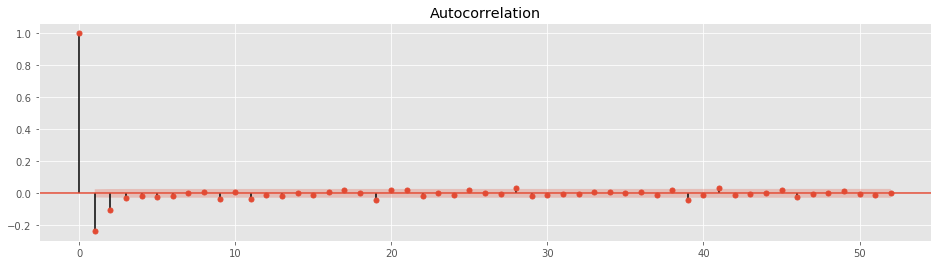

In [37]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(event_diff, lags=52, ax=ax)

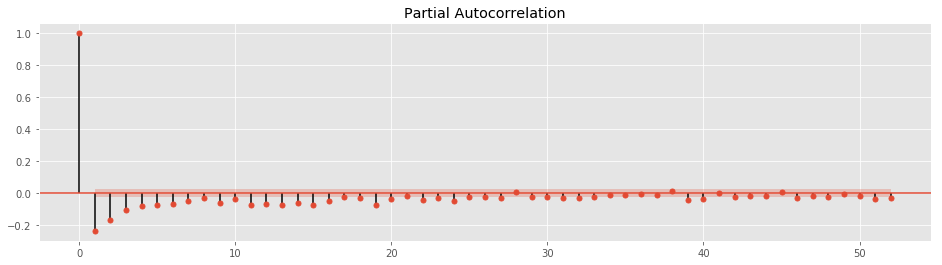

In [38]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(event_diff, lags=52, ax=ax)

In [94]:
# 2 AR, 1 MA
event_model = ARMA(series, order=(2, 1)).fit()

In [95]:
event_series.index = pd.DatetimeIndex(start='01-02-2001', end='12-30-2016', freq='D')
series = event_series.reindex(pd.DatetimeIndex(start='01-02-2001', end='12-30-2016', freq='D'))

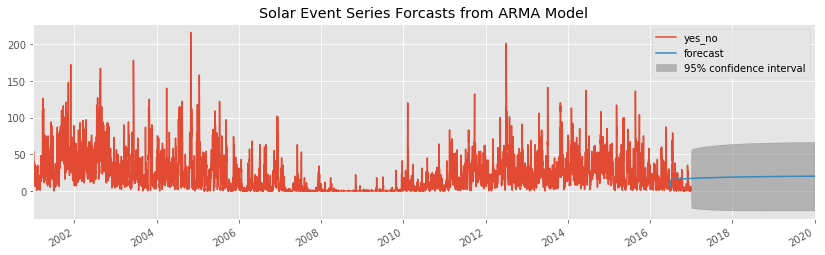

In [96]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(event_series.index, event_series.yes_no)
fig = event_model.plot_predict('2016-06-30', '2020-01-01', dynamic=True, ax=ax, plot_insample=False)
_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
_ = ax.legend(loc="upper right")

_ = ax.set_title("Solar Event Series Forcasts from ARMA Model")

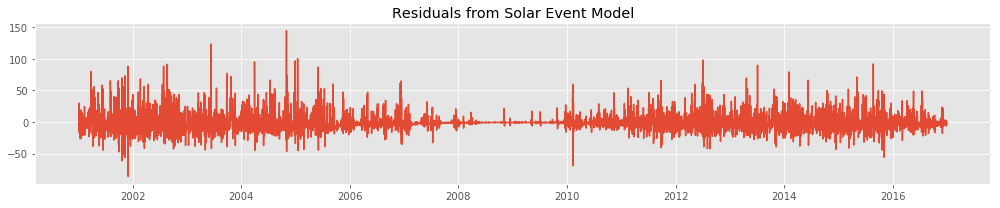

In [53]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(event_model.resid.index, event_model.resid)
ax.set_title("Residuals from Solar Event Model")
plt.tight_layout()